<font size="5"><center> **Exercise 2.a <br>
(Conditional Diffusion Model for MNIST digit dataset)** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

In [1]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-9

In [2]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch as tc
import torch.nn as nn
from torch.optim import AdamW
from torchsummary import summary
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose

import pickle

<font size = '3'>This notebook is essentially the same as Tutorial 9 of this course. The changes made to successfully implement conditioning are in the time embedding layer and the dataset composition using one-hot encoding (including the extra argument of labels in various functions).

<font size = '3'>The below scheduler is the same as in the Tutorial 9.

↓ Noise Scheduler ↓

In [3]:
def get_schedules(beta_1, beta_t, timesteps):
    """
    Linear scheduler.
    Useful to pre-compute all the parameters (even fractions, square roots, etc).
    """
    beta_t = (beta_t - beta_1) * tc.arange(0, timesteps + 1, dtype=tc.float32) / timesteps + beta_1
    sqrt_beta_t = tc.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = tc.log(alpha_t)
    alphabar_t = tc.cumsum(log_alpha_t, dim=0).exp()
    sqrt_abar = tc.sqrt(alphabar_t)
    one_over_sqrt_a = 1 / tc.sqrt(alpha_t)
    sqrt_inv_abar = tc.sqrt(1 - alphabar_t)
    inv_abar_over_sqrt_inv_abar = (1 - alpha_t) / sqrt_inv_abar
    return {
        "alpha": alpha_t,
        "one_over_sqrt_a": one_over_sqrt_a,
        "sqrt_beta": sqrt_beta_t,
        "alphabar": alphabar_t,
        "sqrt_abar": sqrt_abar,
        "sqrt_inv_abar": sqrt_inv_abar,
        "inv_alpha_over_sqrt_inv_abar": inv_abar_over_sqrt_inv_abar,
    }

<font size = '3'>The `ChannelShuffle` operation rearranges tensor channels without altering the tensor's dimensions, enhancing information sharing across channels. The following operation is the same as in the Tutorial 9. 

↓ Channel Shuffling ↓

In [4]:
class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super().__init__()
        self.groups = groups

    def forward(self, x):
        n, c, h, w = x.shape
        x = x.view(n, self.groups, c//self.groups, h, w)         # group
        return x.transpose(1, 2).contiguous().view(n, -1, h, w)  # shuffle

<font size = "3">The `ConvBlock` class in the U-Net architecture, as used in Tutorial 9, employs the SiLU (Swish) activation function for smoother, non-monotonic activation, better gradient propagation, and prevention of dead neurons, leading to improved gradient flow and overall network performance.

↓ The elementary U-Net block ↓

In [5]:
class ConvBlock(nn.Module):
    """The elementary U-Net block."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=1, padding=1
            ),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.SiLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

<font size = '3'>The `UnetDown` and `Encoder` classes define the encoder, while the `UnetUp` and `Decoder` classes define the decoder in the U-Net architecture, both of which are the same as in Tutorial 9, with the encoder focusing on downsampling and feature extraction, and the decoder on upsampling and feature integration to reconstruct high-resolution outputs.

↓ Encoder part of the U-Net ↓

In [6]:
class UnetDown(nn.Module):
    """The elementary encoder block."""
    def __init__(self, in_channels, out_channels, downscale=2):
        super(UnetDown, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels=out_channels),
            nn.MaxPool2d(kernel_size=downscale)
        )
    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):
    def __init__(self, n_features):
        super(Encoder, self).__init__()
        self.initial_features = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=n_features,
                kernel_size=3, stride=1, padding=1
            ),
            nn.GroupNorm(num_groups=8, num_channels=n_features),
            nn.SiLU(),
        )
        self.down1 = UnetDown(in_channels=n_features, out_channels=n_features, downscale=2)
        self.down2 = UnetDown(in_channels=n_features, out_channels=2*n_features, downscale=2)
        self.down3 = UnetDown(in_channels=2*n_features, out_channels=2*n_features, downscale=2)
        self.down4 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3),
            nn.SiLU()
        )
        self.chan_shuffle = ChannelShuffle(groups=2)

    def forward(self, x):
        x_f = self.initial_features(x)
        d1 = self.chan_shuffle(self.down1(x_f))
        d2 = self.chan_shuffle(self.down2(d1))
        d3 = self.chan_shuffle(self.down3(d2))
        latent = self.down4(d3)
        return x_f, d1, d2, d3, latent

↓ Decoder part of the U-Net ↓

In [7]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, upscale=2, extra_dim=0):
        super(UnetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=upscale, stride=upscale, output_padding=extra_dim
            ),
            nn.SiLU(),
            ConvBlock(in_channels=out_channels, out_channels=out_channels),
        )

    def forward(self, x, skip):
        x = tc.cat((x, skip), 1)
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_features):
        super(Decoder, self).__init__()
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=2*n_features, out_channels=2*n_features,
                kernel_size=3, stride=3
            ),
            nn.GroupNorm(num_groups=8, num_channels=2*n_features),
            nn.SiLU(),
        )
        self.up2 = UnetUp(
            in_channels=4*n_features, out_channels=2*n_features,
            upscale=2, extra_dim=1
        )
        self.up3 = UnetUp(
            in_channels=4*n_features, out_channels=n_features,
            upscale=2
        )
        self.up4 = UnetUp(
            in_channels=2*n_features, out_channels=n_features,
            upscale=2
        )
        self.out = nn.Conv2d(
            in_channels=2*n_features, out_channels=1,
            kernel_size=3, stride=1, padding=1
        )
        self.chan_shuffle = ChannelShuffle(groups=2)

    def forward(self, latent, d3, d2, d1, x_f):
        u1 = self.up1(latent)
        u2 = self.chan_shuffle(self.up2(u1, d3))
        u3 = self.chan_shuffle(self.up3(u2, d2))
        u4 = self.chan_shuffle(self.up4(u3, d1))
        return self.out(tc.cat([u4, x_f], dim=1))

<font size = '3'>The modified `TimeEmbedding` class for the conditional diffusion model incorporates class label information by concatenating one-hot encoded labels with timestep data before processing them through two linear layers with SiLU activation, allowing the model to condition the diffusion process on both temporal and class-specific information for generating class-specific outputs.

↓ Time embedding layer ↓

In [8]:
class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, num_classes): # CHNAGE FROM Original TUTORIAL
        super(TimeEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.lin1 = nn.Linear(in_features=1 + num_classes, out_features=embedding_dim//2, bias=False)
        self.lin2 = nn.Linear(in_features=embedding_dim//2, out_features=embedding_dim)
        self.act = nn.SiLU()

    def forward(self, ts, labels):
        ts = ts.view(-1, 1)
        labels = labels.view(-1, self.num_classes)
        t_emb = self.act(self.lin1(tc.cat([ts, labels], dim=1)))
        t_emb = self.lin2(t_emb)
        return t_emb.view(-1, self.embedding_dim, 1, 1)  # add dummy channels to sum with latent

<font size = '3'>The modified `DiffusionModel` class incorporates class conditioning by adding a `num_classes` parameter and the modified `TimeEmbedding`, allowing it to combine time and label embeddings in the forward pass and generate class-specific samples in the `sample` method. 

↓ Diffusion Model ↓

In [9]:
class DiffusionModel(nn.Module):
    def __init__(self, n_features=64, num_classes=10):
        super(DiffusionModel, self).__init__()
        self.encoder = Encoder(n_features=n_features)
        self.decoder = Decoder(n_features=n_features)
        self.time_embedding_layer = TimeEmbedding(embedding_dim=2*n_features, num_classes=num_classes)
        self.num_classes = num_classes

    def forward(self, x, t, labels):
        # pass through encoder:
        x_f, d1, d2, d3, latent = self.encoder(x)
        # get time embedding:
        latent_t_emb = latent + self.time_embedding_layer(t, labels)
        # intermediate decoder steps are not needed:
        return self.decoder(latent_t_emb, d3, d2, d1, x_f)

    def sample(self, n_samples, timesteps, sample_shape, labels, schedules, device):
        # Initialize the noise sample:
        x_t = tc.randn(n_samples, *sample_shape).to(device)
        ones = tc.ones(n_samples).to(device)
        x_i = x_t
        for i in tqdm(range(timesteps, 0, -1)):
            z = tc.randn(n_samples, *sample_shape).to(device) if i > 1 else 0
            t = (i / timesteps) * ones
            eps = self.forward(x_i, t, labels).clone().detach()
            v = schedules["one_over_sqrt_a"][i] * (x_i - eps * schedules["inv_alpha_over_sqrt_inv_abar"][i])
            x_i = v + schedules["sqrt_beta"][i] * z
        return x_i.cpu().detach().numpy().reshape(n_samples, *sample_shape).squeeze(1)


<font size = '3'>The `OneHotEncode` class converts class labels into one-hot encoded vectors, essential for conditioning the diffusion model on class information. When used in conjunction with the `Compose` transformation for the MNIST dataset, it ensures that each target label is transformed into a one-hot encoded vector, facilitating the integration of class-specific information during training and sampling. The use of `Compose` transformation takes place in later cells.

↓ One-Hot Encoding ↓

In [10]:
class OneHotEncode:
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def __call__(self, target):
        return np.eye(self.num_classes)[target].astype(np.float32)

<font size = '3'>The `generate` function produces class-conditioned samples using the diffusion model. 

↓ Generate samples ↓

In [11]:
def generate(model, n_samples, schedules, device, sample_shape=(1, 28, 28), 
             timesteps=1000, title="Conditional Diffusion Sampling", 
             best_epoch = None, load = False):
    
    assert n_samples == 10, "For 2x5 grid, n_samples should be 10."
    labels = tc.eye(10).to(device)  # Generate labels for digits 0-9
    x_hat = model.sample(n_samples, timesteps, sample_shape, labels, schedules, device)
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4),
                            subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False})
    
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
        axis.set_title(f"Label: {i}")
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    if load == False:
        fig.suptitle(title, fontsize=16)
    elif load == True:
        load_title = f"Loaded Conditional Diffusion Generation (Best epoch {best_epoch+1})"
        fig.suptitle(load_title, fontsize=16)
    plt.show()
    plt.close()

<font size = '3'> Below are the functions for saving and loading the best trained conditioned diffusion model. Also the plot of training losses is included below.

In [12]:
# Save and load model checkpoints
def save_model_checkpoint(model, epoch, best_epoch, best_loss, losses, filepath="checkpoints/best_DIFF.pkl"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'epoch': epoch,
        'best_epoch': best_epoch,
        'best_loss': best_loss,
        'losses': losses
    }
    with open(filepath, 'wb') as f:
        pickle.dump(checkpoint, f)

def load_model_checkpoint(filepath="checkpoints/best_DIFF.pkl"):
    with open(filepath, 'rb') as f:
        checkpoint = pickle.load(f)
    return checkpoint

# Plot training losses
def plot_losses(losses):
    smooth_losses = savgol_filter(x=losses, window_length=201, polyorder=7)
    plt.figure()
    plt.semilogy(smooth_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.xlim([0, len(losses)])
    plt.title("Training Losses Over Iterations")
    plt.grid(linestyle=':', which='both')
    plt.show()
    plt.close()

<font size = '3'>The `train_loop` function trains the diffusion model over a specified number of epochs, tracking and saving the best model based on loss, and periodically generating sample outputs for visual inspection.

In [13]:
def train_loop(model, dataloader, optim, schedules, epochs, loss_fn, n_T, n_samples, device):
    
    losses = []
    best_loss = float('inf')
    best_epoch = 0
    print_every = 5

    for epoch in range(epochs):
        print(f"Epoch {epoch+1} : ")
        model.train()
        pbar = tqdm(dataloader)
        for x, labels in pbar:
            try:
                x = x.to(device).view(-1, 1, 28, 28)
                labels = tc.tensor(labels, dtype=tc.float32).to(device)
                timesteps = tc.randint(1, n_T + 1, (x.shape[0],)).to(device)
                eps = tc.randn_like(x)
                optim.zero_grad()
                x_t = schedules["sqrt_abar"][timesteps, None, None, None] * x + \
                      schedules["sqrt_inv_abar"][timesteps, None, None, None] * eps
                t = timesteps / n_T
                eps_hat = model(x_t, t, labels)
                loss = loss_fn(eps_hat, eps)
                loss.backward()
                losses.append(loss.item())
                avg_loss = np.asarray(losses)[-10:].mean()
                pbar.set_description(f"Moving Average Loss: {avg_loss:.4f}")
                optim.step()
            except Exception as e:
                print(f"Error processing batch: {e}")
                continue
        if (epoch + 1) % print_every == 0:
            with tc.no_grad():
                model.eval()
                generate(model, n_samples, schedules, device, title=f"Epoch {epoch+1}")
                model.train()
        # Save model
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_epoch = epoch
            save_model_checkpoint(model, epoch, best_epoch, best_loss, losses)

    return losses

using cuda
Epoch 1 : 


  0%|          | 0/469 [00:00<?, ?it/s]C:\Users\sifak\AppData\Local\Temp\ipykernel_19512\509209319.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = tc.tensor(labels, dtype=tc.float32).to(device)
Moving Average Loss: 0.0522: 100%|██████████| 469/469 [01:18<00:00,  5.96it/s]


Epoch 2 : 


Moving Average Loss: 0.0382: 100%|██████████| 469/469 [01:17<00:00,  6.02it/s]


Epoch 3 : 


Moving Average Loss: 0.0360: 100%|██████████| 469/469 [01:18<00:00,  6.01it/s]


Epoch 4 : 


Moving Average Loss: 0.0299: 100%|██████████| 469/469 [01:17<00:00,  6.08it/s]


Epoch 5 : 


100%|██████████| 1000/1000 [00:06<00:00, 158.80it/s]


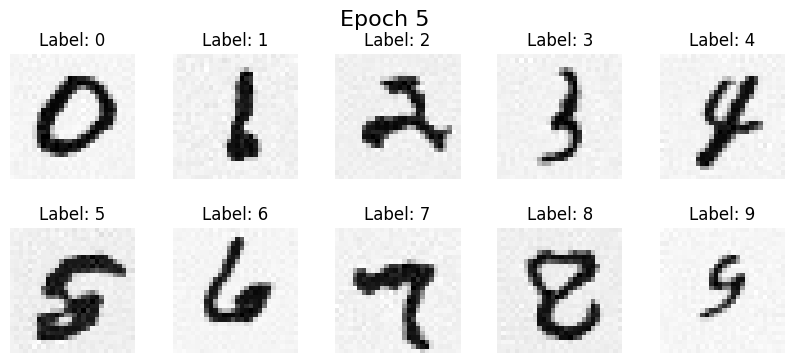

Epoch 6 : 


Moving Average Loss: 0.0286: 100%|██████████| 469/469 [01:23<00:00,  5.63it/s]


Epoch 7 : 


Moving Average Loss: 0.0274: 100%|██████████| 469/469 [01:20<00:00,  5.84it/s]


Epoch 8 : 


Moving Average Loss: 0.0280: 100%|██████████| 469/469 [01:25<00:00,  5.48it/s]


Epoch 9 : 


Moving Average Loss: 0.0281: 100%|██████████| 469/469 [01:24<00:00,  5.54it/s]


Epoch 10 : 


100%|██████████| 1000/1000 [00:06<00:00, 164.43it/s]


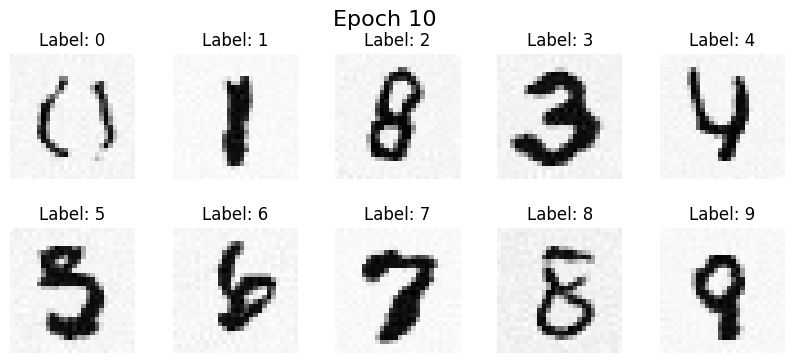

Epoch 11 : 


Moving Average Loss: 0.0289: 100%|██████████| 469/469 [01:24<00:00,  5.55it/s]


Epoch 12 : 


Moving Average Loss: 0.0268: 100%|██████████| 469/469 [01:23<00:00,  5.61it/s]


Epoch 13 : 


Moving Average Loss: 0.0272: 100%|██████████| 469/469 [01:26<00:00,  5.42it/s]


Epoch 14 : 


Moving Average Loss: 0.0267: 100%|██████████| 469/469 [01:26<00:00,  5.45it/s]


Epoch 15 : 


100%|██████████| 1000/1000 [00:06<00:00, 162.35it/s]


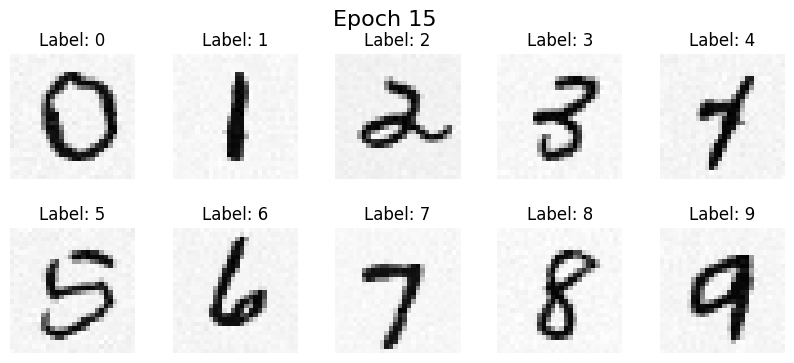

Epoch 16 : 


Moving Average Loss: 0.0238: 100%|██████████| 469/469 [01:26<00:00,  5.42it/s]


Epoch 17 : 


Moving Average Loss: 0.0254: 100%|██████████| 469/469 [01:27<00:00,  5.35it/s]


Epoch 18 : 


Moving Average Loss: 0.0261: 100%|██████████| 469/469 [01:23<00:00,  5.60it/s]


Epoch 19 : 


Moving Average Loss: 0.0256: 100%|██████████| 469/469 [01:17<00:00,  6.06it/s]


Epoch 20 : 


100%|██████████| 1000/1000 [00:05<00:00, 182.71it/s]


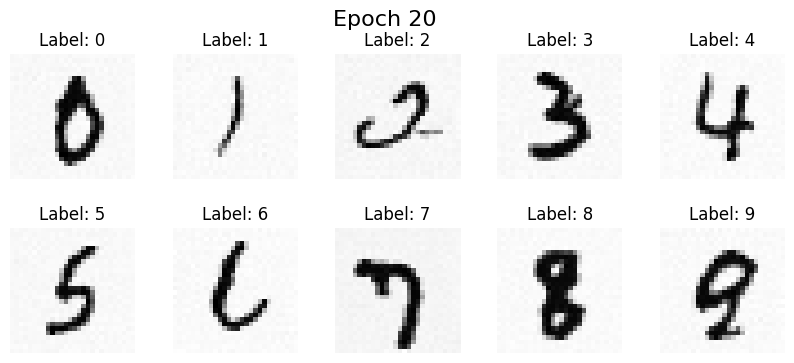

Epoch 21 : 


Moving Average Loss: 0.0250: 100%|██████████| 469/469 [01:13<00:00,  6.40it/s]


Epoch 22 : 


Moving Average Loss: 0.0240: 100%|██████████| 469/469 [01:18<00:00,  5.99it/s]


Epoch 23 : 


Moving Average Loss: 0.0250: 100%|██████████| 469/469 [01:33<00:00,  4.99it/s]


Epoch 24 : 


Moving Average Loss: 0.0253: 100%|██████████| 469/469 [01:30<00:00,  5.16it/s]


Epoch 25 : 


100%|██████████| 1000/1000 [00:05<00:00, 170.49it/s]


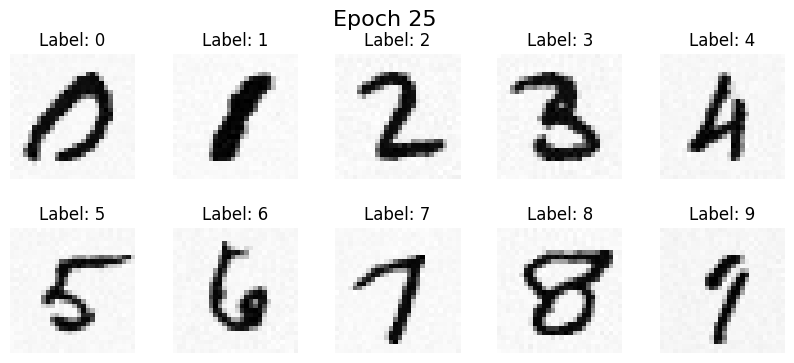

Epoch 26 : 


Moving Average Loss: 0.0238: 100%|██████████| 469/469 [01:28<00:00,  5.29it/s]


Epoch 27 : 


Moving Average Loss: 0.0230: 100%|██████████| 469/469 [01:28<00:00,  5.29it/s]


Epoch 28 : 


Moving Average Loss: 0.0240: 100%|██████████| 469/469 [01:28<00:00,  5.32it/s]


Epoch 29 : 


Moving Average Loss: 0.0235: 100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


Epoch 30 : 


100%|██████████| 1000/1000 [00:05<00:00, 176.13it/s]


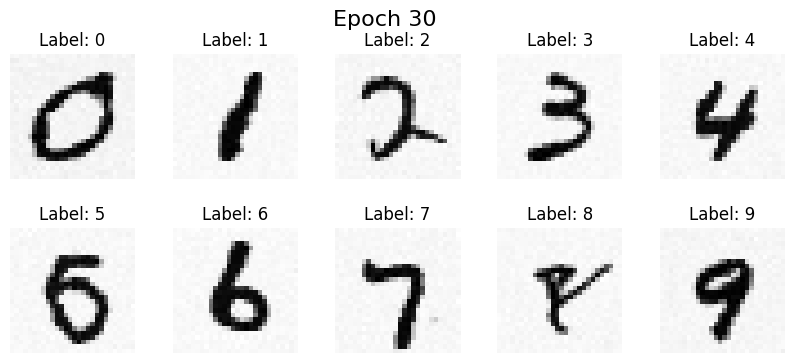

Epoch 31 : 


Moving Average Loss: 0.0234: 100%|██████████| 469/469 [01:20<00:00,  5.80it/s]


Epoch 32 : 


Moving Average Loss: 0.0240: 100%|██████████| 469/469 [01:17<00:00,  6.02it/s]


Epoch 33 : 


Moving Average Loss: 0.0235: 100%|██████████| 469/469 [01:18<00:00,  5.98it/s]


Epoch 34 : 


Moving Average Loss: 0.0238: 100%|██████████| 469/469 [01:19<00:00,  5.87it/s]


Epoch 35 : 


100%|██████████| 1000/1000 [00:05<00:00, 168.92it/s]


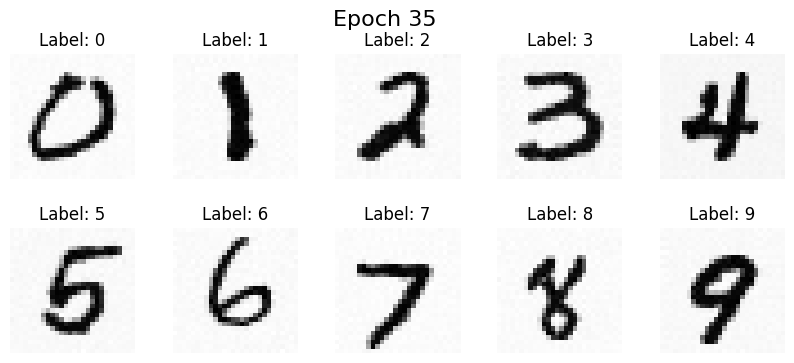

Epoch 36 : 


Moving Average Loss: 0.0239: 100%|██████████| 469/469 [01:16<00:00,  6.14it/s]


Epoch 37 : 


Moving Average Loss: 0.0221: 100%|██████████| 469/469 [01:25<00:00,  5.48it/s]


Epoch 38 : 


Moving Average Loss: 0.0231: 100%|██████████| 469/469 [01:31<00:00,  5.14it/s]


Epoch 39 : 


Moving Average Loss: 0.0226: 100%|██████████| 469/469 [01:29<00:00,  5.26it/s]


Epoch 40 : 


100%|██████████| 1000/1000 [00:06<00:00, 163.07it/s]


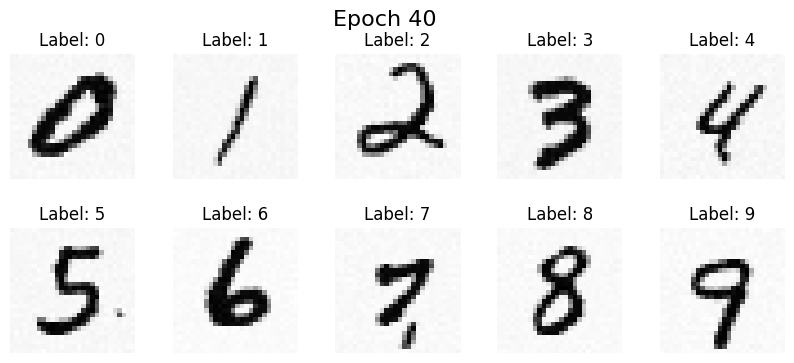

Epoch 41 : 


Moving Average Loss: 0.0234: 100%|██████████| 469/469 [01:28<00:00,  5.28it/s]


Epoch 42 : 


Moving Average Loss: 0.0214: 100%|██████████| 469/469 [01:28<00:00,  5.31it/s]


Epoch 43 : 


Moving Average Loss: 0.0224: 100%|██████████| 469/469 [01:18<00:00,  5.96it/s]


Epoch 44 : 


Moving Average Loss: 0.0213: 100%|██████████| 469/469 [01:17<00:00,  6.07it/s]


Epoch 45 : 


100%|██████████| 1000/1000 [00:06<00:00, 165.30it/s]


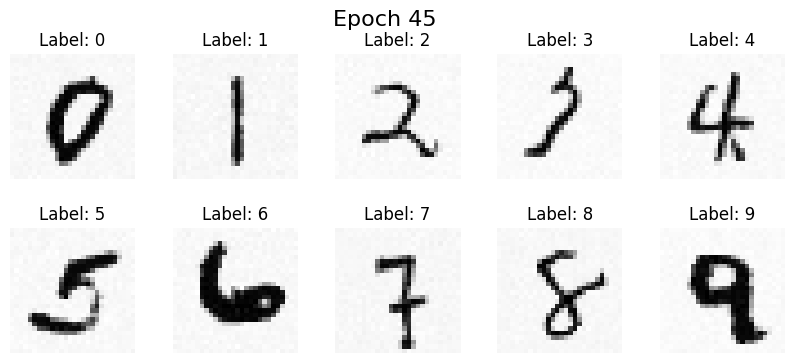

Epoch 46 : 


Moving Average Loss: 0.0205: 100%|██████████| 469/469 [01:24<00:00,  5.56it/s]


Epoch 47 : 


Moving Average Loss: 0.0221: 100%|██████████| 469/469 [01:23<00:00,  5.64it/s]


Epoch 48 : 


Moving Average Loss: 0.0210: 100%|██████████| 469/469 [01:24<00:00,  5.54it/s]


Epoch 49 : 


Moving Average Loss: 0.0215: 100%|██████████| 469/469 [01:24<00:00,  5.52it/s]


Epoch 50 : 


100%|██████████| 1000/1000 [00:05<00:00, 166.85it/s]


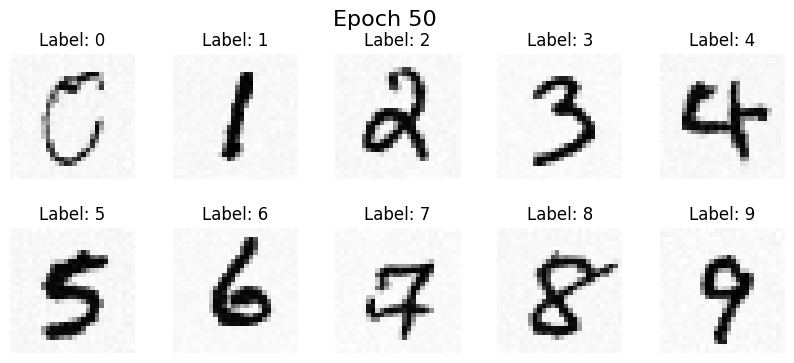

Epoch 51 : 


Moving Average Loss: 0.0228: 100%|██████████| 469/469 [01:19<00:00,  5.90it/s]


Epoch 52 : 


Moving Average Loss: 0.0224: 100%|██████████| 469/469 [01:20<00:00,  5.82it/s]


Epoch 53 : 


Moving Average Loss: 0.0239: 100%|██████████| 469/469 [01:21<00:00,  5.74it/s]


Epoch 54 : 


Moving Average Loss: 0.0219: 100%|██████████| 469/469 [01:15<00:00,  6.24it/s]


Epoch 55 : 


100%|██████████| 1000/1000 [00:05<00:00, 197.06it/s]


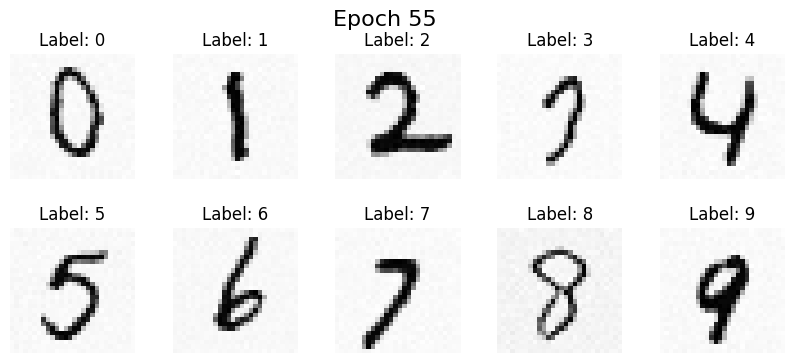

Epoch 56 : 


Moving Average Loss: 0.0226: 100%|██████████| 469/469 [01:14<00:00,  6.31it/s]


Epoch 57 : 


Moving Average Loss: 0.0206: 100%|██████████| 469/469 [01:14<00:00,  6.33it/s]


Epoch 58 : 


Moving Average Loss: 0.0231: 100%|██████████| 469/469 [01:14<00:00,  6.33it/s]


Epoch 59 : 


Moving Average Loss: 0.0235: 100%|██████████| 469/469 [01:14<00:00,  6.34it/s]


Epoch 60 : 


100%|██████████| 1000/1000 [00:05<00:00, 196.57it/s]


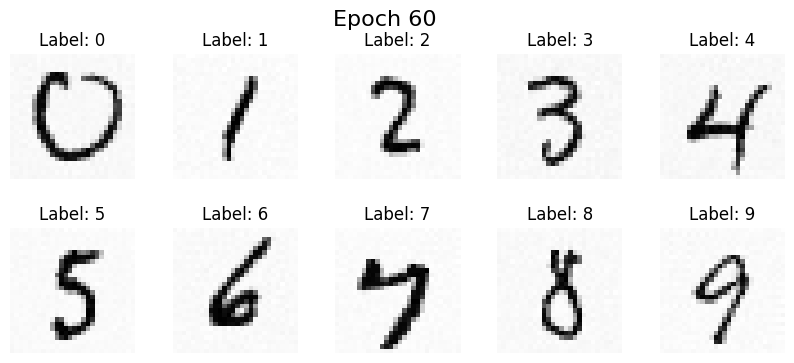

Epoch 61 : 


Moving Average Loss: 0.0225: 100%|██████████| 469/469 [01:14<00:00,  6.32it/s]


Epoch 62 : 


Moving Average Loss: 0.0228: 100%|██████████| 469/469 [01:13<00:00,  6.34it/s]


Epoch 63 : 


Moving Average Loss: 0.0218: 100%|██████████| 469/469 [01:11<00:00,  6.54it/s]


Epoch 64 : 


Moving Average Loss: 0.0224: 100%|██████████| 469/469 [01:10<00:00,  6.64it/s]


Epoch 65 : 


100%|██████████| 1000/1000 [00:05<00:00, 193.95it/s]


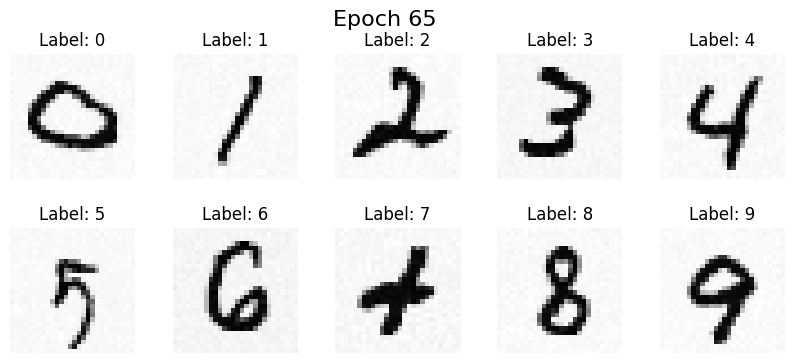

Epoch 66 : 


Moving Average Loss: 0.0249: 100%|██████████| 469/469 [01:20<00:00,  5.82it/s]


Epoch 67 : 


Moving Average Loss: 0.0234: 100%|██████████| 469/469 [01:17<00:00,  6.05it/s]


Epoch 68 : 


Moving Average Loss: 0.0219: 100%|██████████| 469/469 [01:30<00:00,  5.18it/s]


Epoch 69 : 


Moving Average Loss: 0.0212: 100%|██████████| 469/469 [01:27<00:00,  5.38it/s]


Epoch 70 : 


100%|██████████| 1000/1000 [00:06<00:00, 159.37it/s]


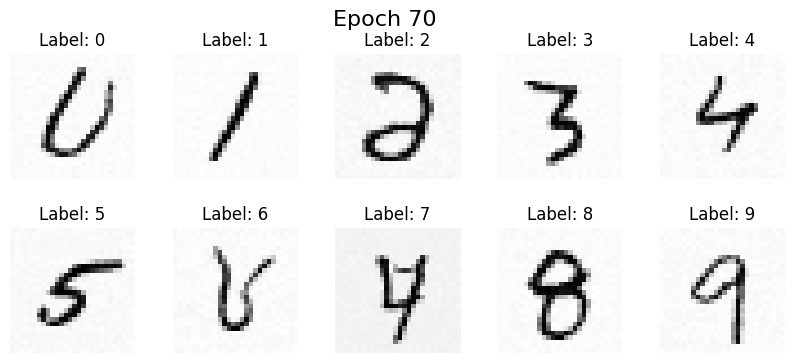

Epoch 71 : 


Moving Average Loss: 0.0242: 100%|██████████| 469/469 [01:35<00:00,  4.89it/s]


Epoch 72 : 


Moving Average Loss: 0.0221: 100%|██████████| 469/469 [01:29<00:00,  5.26it/s]


Epoch 73 : 


Moving Average Loss: 0.0223: 100%|██████████| 469/469 [01:20<00:00,  5.82it/s]


Epoch 74 : 


Moving Average Loss: 0.0226: 100%|██████████| 469/469 [01:10<00:00,  6.63it/s]


Epoch 75 : 


100%|██████████| 1000/1000 [00:05<00:00, 196.13it/s]


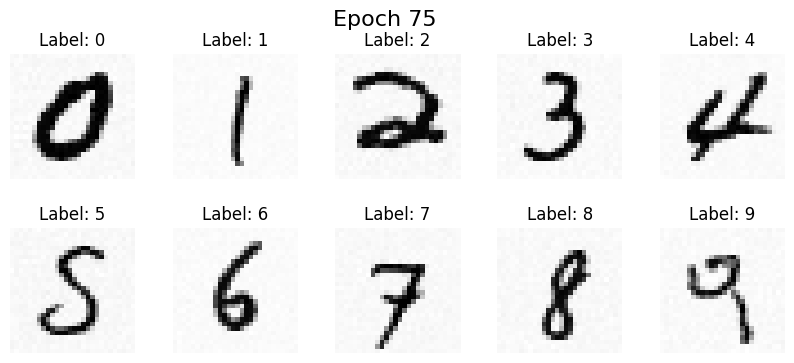

Epoch 76 : 


Moving Average Loss: 0.0221: 100%|██████████| 469/469 [01:10<00:00,  6.63it/s]


Epoch 77 : 


Moving Average Loss: 0.0233: 100%|██████████| 469/469 [01:10<00:00,  6.61it/s]


Epoch 78 : 


Moving Average Loss: 0.0209: 100%|██████████| 469/469 [01:10<00:00,  6.61it/s]


Epoch 79 : 


Moving Average Loss: 0.0219: 100%|██████████| 469/469 [01:10<00:00,  6.63it/s]


Epoch 80 : 


100%|██████████| 1000/1000 [00:05<00:00, 192.68it/s]


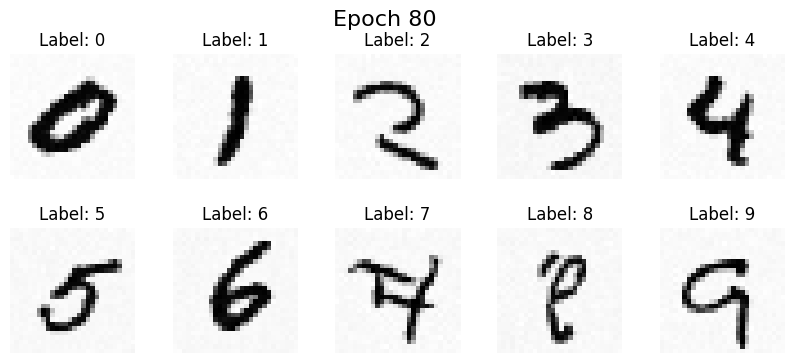

Epoch 81 : 


Moving Average Loss: 0.0218: 100%|██████████| 469/469 [01:10<00:00,  6.63it/s]


Epoch 82 : 


Moving Average Loss: 0.0220: 100%|██████████| 469/469 [01:11<00:00,  6.60it/s]


Epoch 83 : 


Moving Average Loss: 0.0229: 100%|██████████| 469/469 [01:11<00:00,  6.60it/s]


Epoch 84 : 


Moving Average Loss: 0.0216: 100%|██████████| 469/469 [01:10<00:00,  6.62it/s]


Epoch 85 : 


100%|██████████| 1000/1000 [00:05<00:00, 194.68it/s]


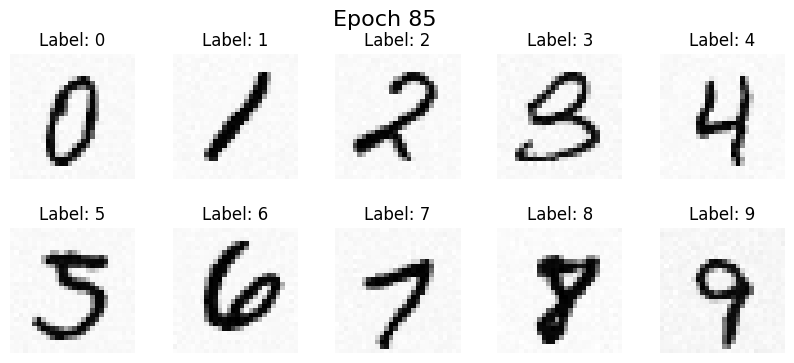

Epoch 86 : 


Moving Average Loss: 0.0210: 100%|██████████| 469/469 [01:11<00:00,  6.60it/s]


Epoch 87 : 


Moving Average Loss: 0.0226: 100%|██████████| 469/469 [01:10<00:00,  6.62it/s]


Epoch 88 : 


Moving Average Loss: 0.0219: 100%|██████████| 469/469 [01:10<00:00,  6.61it/s]


Epoch 89 : 


Moving Average Loss: 0.0225: 100%|██████████| 469/469 [01:10<00:00,  6.62it/s]


Epoch 90 : 


100%|██████████| 1000/1000 [00:05<00:00, 194.11it/s]


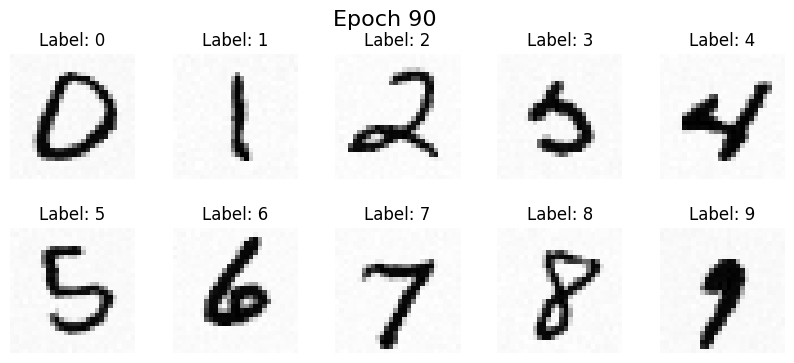

Epoch 91 : 


Moving Average Loss: 0.0221: 100%|██████████| 469/469 [01:11<00:00,  6.59it/s]


Epoch 92 : 


Moving Average Loss: 0.0218: 100%|██████████| 469/469 [01:11<00:00,  6.60it/s]


Epoch 93 : 


Moving Average Loss: 0.0201: 100%|██████████| 469/469 [01:11<00:00,  6.59it/s]


Epoch 94 : 


Moving Average Loss: 0.0208: 100%|██████████| 469/469 [01:11<00:00,  6.59it/s]


Epoch 95 : 


100%|██████████| 1000/1000 [00:05<00:00, 194.84it/s]


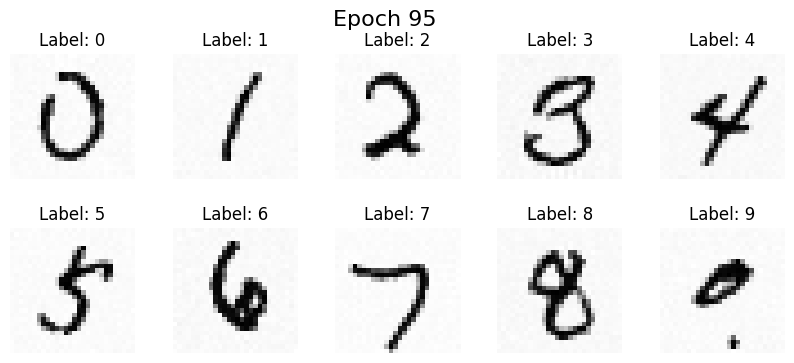

Epoch 96 : 


Moving Average Loss: 0.0209: 100%|██████████| 469/469 [01:11<00:00,  6.53it/s]


Epoch 97 : 


Moving Average Loss: 0.0203: 100%|██████████| 469/469 [01:11<00:00,  6.55it/s]


Epoch 98 : 


Moving Average Loss: 0.0220: 100%|██████████| 469/469 [01:11<00:00,  6.56it/s]


Epoch 99 : 


Moving Average Loss: 0.0225: 100%|██████████| 469/469 [01:11<00:00,  6.60it/s]


Epoch 100 : 


100%|██████████| 1000/1000 [00:05<00:00, 194.05it/s]


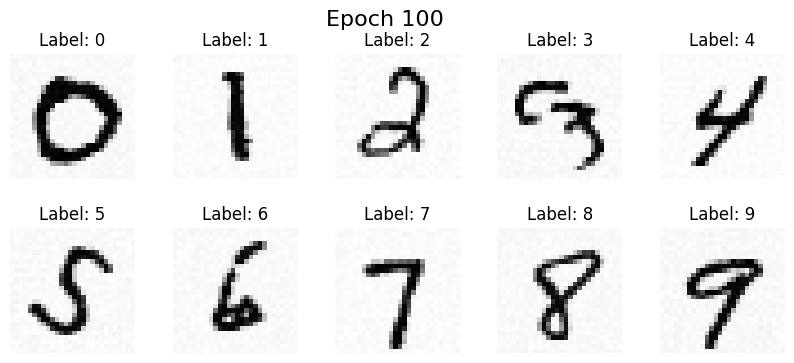

In [14]:
# TRAINING MAIN
seed = 42
np.random.seed(seed)
tc.manual_seed(seed)
tc.set_default_dtype(tc.float32)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"using {device}")

# Model parameters
length, height = 28, 28  # MNIST is 28*28 images
input_shape = (1, height, length)
no_features = 128
epochs = 100
batch_size = 128
num_classes = 10
n_samples = 10
lr = 1e-3
n_T = 1000
betas = [1e-4, 0.02]

# Dataset and DataLoader
# Setting `num_workers=0` which avoids issues related to multi-processing

transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
target_transform = OneHotEncode(num_classes)
dataset = MNIST("./data", train=True, download=True, transform=transform, target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)  # Set num_workers to 0 for debugging

# # Check only first 3 batches to see shapes
# try:
#     for i, (x, labels) in enumerate(dataloader):
#         print(f"Batch {i+1}: x shape = {x.shape}, labels shape = {labels.shape}")
#         if i == 2: 
#             break
# except Exception as e:
#     print(f"Error: {e}")

# Model, loss function, optimizer, and schedules
model = DiffusionModel(n_features=no_features).to(device)
loss_fn = nn.MSELoss()
optim = AdamW(params=model.parameters(), lr=lr)
schedules = get_schedules(betas[0], betas[1], n_T)
schedules = {key: val.to(device) for key, val in schedules.items()}

# Train
train_losses = train_loop(model, dataloader, optim, schedules, epochs, loss_fn, n_T, n_samples, device)

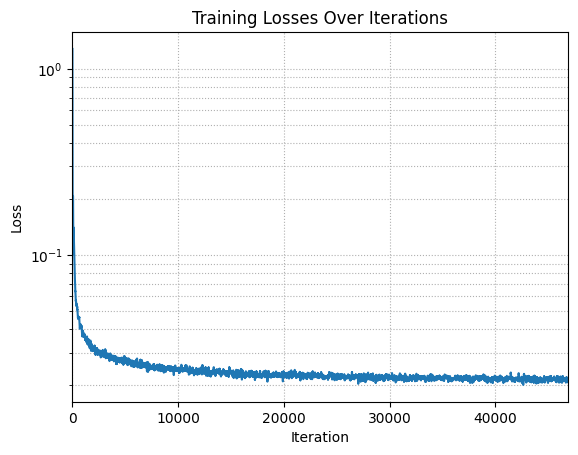

In [15]:
# Plot the training Losses

plot_losses(train_losses)

Lowest LOSS : 0.020101499184966086 , on EPOCH : 93


100%|██████████| 1000/1000 [00:11<00:00, 85.13it/s] 


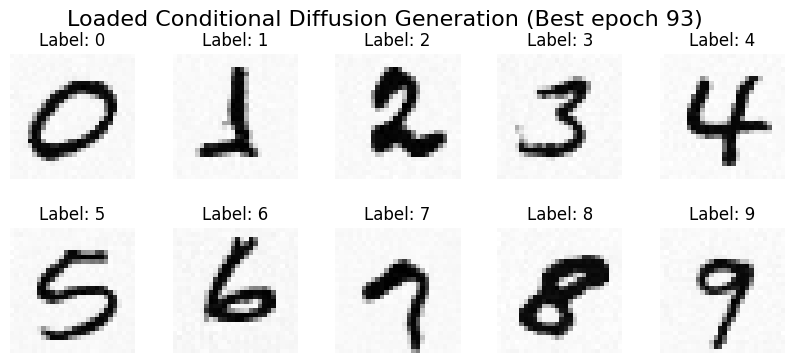

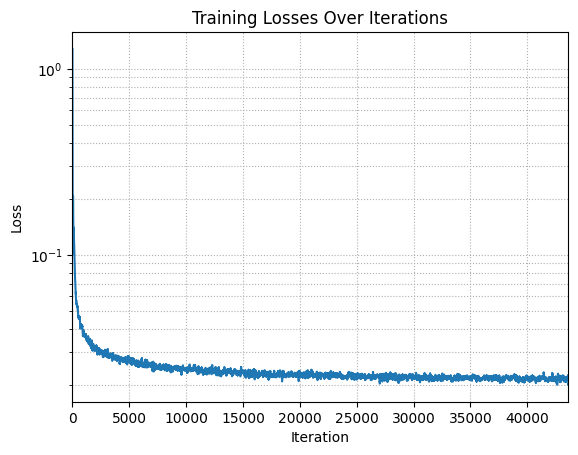

In [14]:
# MAIN (LOADING TRAINED CONDITIONED DIFFUSION MODEL)
seed = 42
np.random.seed(seed)
tc.manual_seed(seed)
tc.set_default_dtype(tc.float32)
device = 'cuda' if tc.cuda.is_available() else 'cpu'

# Model parameters
length, height = 28, 28  # MNIST is 28x28 images
input_shape = (1, height, length)
no_features = 128
epochs = 100
batch_size = 128
num_classes = 10
n_samples = 10
lr = 1e-3
n_T = 1000
betas = [1e-4, 0.02]

# Dataset and DataLoader
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
target_transform = OneHotEncode(num_classes)
dataset = MNIST("./data", train=True, download=True, transform=transform, target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)  

# Model, loss function, optimizer, and schedules
model = DiffusionModel(n_features=no_features).to(device)
loss_fn = nn.MSELoss()
optim = AdamW(params=model.parameters(), lr=lr)
schedules = get_schedules(betas[0], betas[1], n_T)
schedules = {key: val.to(device) for key, val in schedules.items()}

# Load the best model and plot the losses
checkpoint = load_model_checkpoint()
model.load_state_dict(checkpoint['model_state_dict'])
best_epoch = checkpoint['best_epoch']
best_loss = checkpoint['best_loss']
loaded_losses = checkpoint['losses']

print('Lowest LOSS :',best_loss,', on EPOCH :',best_epoch+1)
# Generate samples using the loaded model
generate(model, n_samples, schedules, device, sample_shape=input_shape, 
         timesteps=n_T, best_epoch = best_epoch, load = True)

# Plot losses
plot_losses(checkpoint['losses'])